In [1]:
# imports

import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import keras
import pickle
import h5py

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from PIL import Image

from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Read in the CSV with photo_ids and labels
# 'food': 0, 'inside': 1, 'drink': 2, 'outside': 3, 'menu': 4

# photos = pd.read_csv('../../../data/yelp/photos_with_labels.csv') # this is for my laptop's path

photos = pd.read_csv('../../../data/photos_with_labels.csv') # desktop path

In [3]:
# Sort the dataframe to be alphabetical by the photo_id (file name)

photos.sort_values(by = 'photo_id', inplace = True)
photos.reset_index(inplace = True)
photos.drop('index', axis = 1, inplace = True)
photos.head()

,photo_id,label
0,--3uF9gf2WttniseRLlI6g.jpg,1
1,--4v2HCSXi092RwfidxlMg.jpg,0
2,--5FyXiUudlvrJyUCvpZJA.jpg,0
3,--6kOAkha3ULjhhw32KN1w.jpg,2
4,--8aLa0rf2gfOjA6kCC3WQ.jpg,1


In [4]:
main_dir = '../../../data/photos/'
images = os.listdir(main_dir)
print(len(images))

200000


In [5]:
images[0]

'--3uF9gf2WttniseRLlI6g.jpg'

In [6]:
photos.head()

,photo_id,label
0,--3uF9gf2WttniseRLlI6g.jpg,1
1,--4v2HCSXi092RwfidxlMg.jpg,0
2,--5FyXiUudlvrJyUCvpZJA.jpg,0
3,--6kOAkha3ULjhhw32KN1w.jpg,2
4,--8aLa0rf2gfOjA6kCC3WQ.jpg,1


In [54]:
# Make sure to only do this once

# photos['photo_id'] = photos['photo_id'] + '.jpg'

In [6]:
photos.dtypes

photo_id    object
label        int64
dtype: object

In [19]:
photos.head()

,photo_id,label
0,--3uF9gf2WttniseRLlI6g.jpg,1
1,--4v2HCSXi092RwfidxlMg.jpg,0
2,--5FyXiUudlvrJyUCvpZJA.jpg,0
3,--6kOAkha3ULjhhw32KN1w.jpg,2
4,--8aLa0rf2gfOjA6kCC3WQ.jpg,1


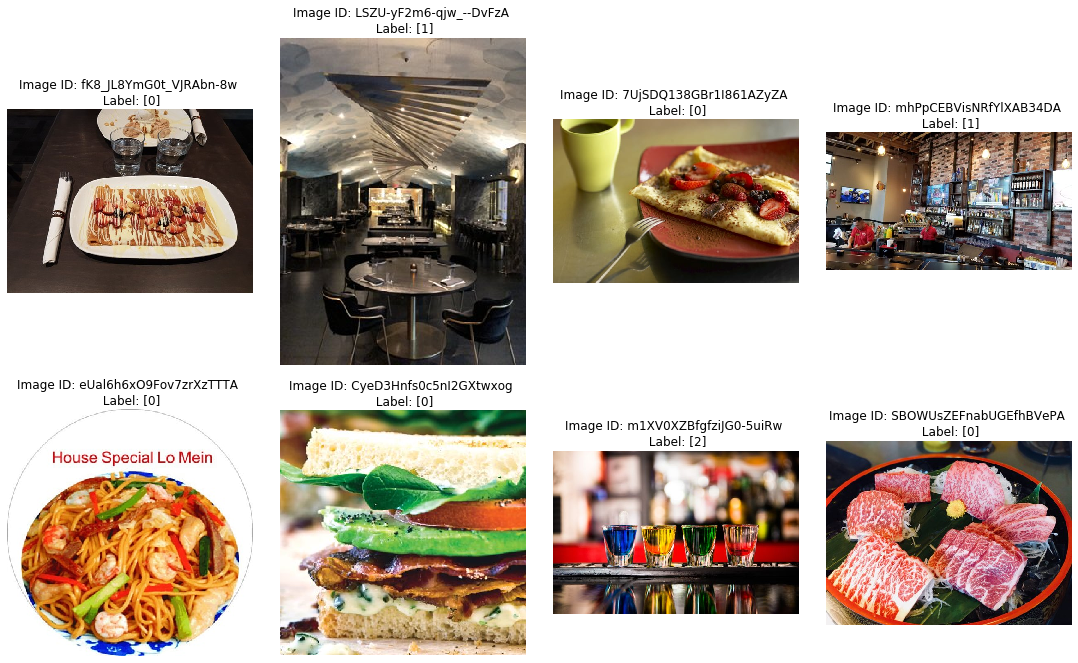

In [9]:
# Randomly sample 8 images
imgs_samples = random.sample(images, 8)

# Plot random sample of 8 images
plt.figure(figsize=(15, 10))
for i in range(len(imgs_samples)):
    # OpenCV2 reads images in BGR format
    img = cv2.imread(os.path.join(main_dir, imgs_samples[i]))
    # Switch color channels to RGB to make compatible with matplotlib imshow func
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Grab image's photo ID and labels
    photo = imgs_samples[i][:-4]
    label = photos.loc[photos['photo_id'] == imgs_samples[i]]['label'].values
    # Annotate each image with image ID, and labels
#     title = "Image ID: " + photo + '\nLabels: ' + label
    # Plot the image
    plt.subplot(2, 4, i+1)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image ID: {photo} \n Label: {label}")
plt.show()

In [13]:
def load_img_shapes(path_to_img):
    """ Return only the shape of an image (width, height, channels) """
    return cv2.imread(path_to_img).shape

In [39]:
# This shows that images greatly differ in size - will need to resize them

# Initialize arrays to hold image sizes
image_shapes = []

# Load in training/testing image sizes
for i in range(len(images)):
    img_path = os.path.join(main_dir, images[i])
    image_shapes.append(load_img_shapes(img_path))

# Store training image sizes in dataframe
df_train = pd.DataFrame({'Shapes': image_shapes})
image_counts = df_train['Shapes'].value_counts()
# # Store testing image sizes in dataframe
# df_test = pd.DataFrame({'Shapes': test_shapes})
# test_counts = df_test['Shapes'].value_counts()

print("Image Shapes: First 100")
for i in range(100):
    print("Shape %s counts: %d" % (image_counts.index[i], image_counts.values[i]))
# print("*"*50)
# print("Testing Image Shapes: First 100")
# for i in range(100):
#     print("Shape %s counts: %d" % (test_counts.index[i], test_counts.values[i]))

Image Shapes: First 100
Shape (400, 533, 3) counts: 41654
Shape (400, 300, 3) counts: 29516
Shape (400, 600, 3) counts: 28915
Shape (400, 400, 3) counts: 22320
Shape (399, 600, 3) counts: 10126
Shape (337, 600, 3) counts: 8925
Shape (400, 534, 3) counts: 5291
Shape (400, 266, 3) counts: 5214
Shape (398, 600, 3) counts: 3100
Shape (400, 320, 3) counts: 2176
Shape (400, 225, 3) counts: 1802
Shape (397, 600, 3) counts: 1297
Shape (400, 598, 3) counts: 1010
Shape (400, 267, 3) counts: 965
Shape (400, 224, 3) counts: 898
Shape (400, 535, 3) counts: 799
Shape (291, 600, 3) counts: 631
Shape (150, 300, 3) counts: 600
Shape (400, 265, 3) counts: 545
Shape (400, 500, 3) counts: 491
Shape (400, 560, 3) counts: 359
Shape (400, 597, 3) counts: 358
Shape (400, 298, 3) counts: 330
Shape (336, 600, 3) counts: 322
Shape (300, 600, 3) counts: 309
Shape (400, 299, 3) counts: 303
Shape (400, 550, 3) counts: 277
Shape (338, 600, 3) counts: 276
Shape (396, 600, 3) counts: 252
Shape (324, 486, 3) counts: 23

In [61]:
# photos.to_csv('../../../data/yelp/photos_with_labels.csv', index = False)
# pics.to_csv('../../../data/yelp/pics_with_labels.csv')

In [7]:
datagen=ImageDataGenerator(samplewise_center=True,
                           samplewise_std_normalization=True,
                           rotation_range=20,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=16,
                           zoom_range=[0.9, 1.1],
                           fill_mode="constant",
                           cval=255,
                           horizontal_flip=True,
                           vertical_flip=True,
                           rescale=1./255.,
                           validation_split=0.25)

In [8]:
photos['label'] = photos['label'].astype(str)

In [9]:
train_generator = datagen.flow_from_dataframe(
                                            dataframe=photos,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="training",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))
valid_generator = datagen.flow_from_dataframe(
                                            dataframe=photos,
                                            directory=main_dir,
                                            x_col="photo_id",
                                            y_col="label",
                                            subset="validation",
                                            batch_size=100,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            interpolation="bilinear",
                                            target_size=(256, 256))

Found 150000 validated image filenames belonging to 5 classes.
Found 50000 validated image filenames belonging to 5 classes.


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6154846689432060518
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9214934385
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5378164813632531057
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [14]:
train_generator[0][0][0].shape

(256, 256, 3)

In [15]:
model = Sequential()
model.add(Conv2D(filters = 16,
                 kernel_size = 3,
                 activation = 'relu',
                 input_shape = (256, 256, 3)))

model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(32,
                 kernel_size = 3,
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(64,
                 kernel_size = 3,
                 activation = 'relu'))

model.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
model.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
model.add(Dropout(0.3))

# Add a final layer with 10 neurons.
model.add(Dense(5, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

W0818 17:54:35.231046  3724 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 17:54:35.257974  3724 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 17:54:35.263957  3724 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 17:54:35.283905  3724 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0818 17:54:35.335766  3724 deprecation_wrapper.py:119] From C:\Users\Bruno\Ana

In [16]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0.01,
                           patience = 3,
                           verbose = 1,
                           mode = 'auto')

history = model.fit_generator(train_generator,
                              steps_per_epoch = 300,
                              epochs= 30,
                              validation_data = valid_generator,
                              validation_steps = 100,
                              callbacks = [early_stop])

W0818 17:55:20.005215  3724 deprecation.py:323] From C:\Users\Bruno\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
300/300 [==============================] - 669s 2s/step - loss: 0.9284 - acc: 0.6822 - val_loss: 0.6686 - val_acc: 0.7728
Epoch 2/30
300/300 [==============================] - 701s 2s/step - loss: 0.6983 - acc: 0.7727 - val_loss: 0.6069 - val_acc: 0.7880
Epoch 3/30
300/300 [==============================] - 737s 2s/step - loss: 0.6358 - acc: 0.7892 - val_loss: 0.5716 - val_acc: 0.8058
Epoch 4/30
300/300 [==============================] - 740s 2s/step - loss: 0.6112 - acc: 0.7937 - val_loss: 0.5414 - val_acc: 0.8062
Epoch 5/30
300/300 [==============================] - 738s 2s/step - loss: 0.5704 - acc: 0.8069 - val_loss: 0.5680 - val_acc: 0.8036
Epoch 6/30
300/300 [==============================] - 754s 3s/step - loss: 0.5506 - acc: 0.8137 - val_loss: 0.4854 - val_acc: 0.8322
Epoch 7/30
300/300 [==============================] - 755s 3s/step - loss: 0.5353 - acc: 0.8196 - val_loss: 0.5043 - val_acc: 0.8284
Epoch 8/30
300/300 [==============================] - 756s 3s/step - 

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
__________

In [21]:
# with open('3conv2densemodel15epoch.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [18]:
# model.predict_generator(valid_generator)

In [22]:
model_2 = Sequential()
model_2.add(Conv2D(filters = 16,
                 kernel_size = 3,
                 activation = 'relu',
                 input_shape = (256, 256, 3)))

model_2.add(MaxPooling2D(pool_size = 2))

model_2.add(Conv2D(32,
                 kernel_size = 3,
                 activation = 'relu'))

model_2.add(MaxPooling2D(pool_size = 2))

model_2.add(Conv2D(64,
                 kernel_size = 3,
                 activation = 'relu'))

model_2.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
model_2.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
model_2.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
model_2.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
model_2.add(Dropout(0.3))

# Add a final layer with 10 neurons.
model_2.add(Dense(5, activation='softmax'))

# Compile model
model_2.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [23]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0,
                           patience = 5,
                           verbose = 1,
                           mode = 'auto')

hist_2 = model_2.fit_generator(train_generator,
                              steps_per_epoch = 300,
                              epochs= 30,
                              validation_data = valid_generator,
                              validation_steps = 100,
                              callbacks = [early_stop])

Epoch 1/30
300/300 [==============================] - 710s 2s/step - loss: 0.9697 - acc: 0.6718 - val_loss: 0.6900 - val_acc: 0.7629
Epoch 2/30
300/300 [==============================] - 683s 2s/step - loss: 0.7114 - acc: 0.7617 - val_loss: 0.6263 - val_acc: 0.7798
Epoch 3/30
300/300 [==============================] - 699s 2s/step - loss: 0.6528 - acc: 0.7792 - val_loss: 0.5581 - val_acc: 0.7991
Epoch 4/30
300/300 [==============================] - 747s 2s/step - loss: 0.6222 - acc: 0.7852 - val_loss: 0.5224 - val_acc: 0.8194
Epoch 5/30
300/300 [==============================] - 732s 2s/step - loss: 0.5756 - acc: 0.8071 - val_loss: 0.5310 - val_acc: 0.8160
Epoch 6/30
300/300 [==============================] - 740s 2s/step - loss: 0.5650 - acc: 0.8090 - val_loss: 0.5090 - val_acc: 0.8236
Epoch 7/30
300/300 [==============================] - 742s 2s/step - loss: 0.5453 - acc: 0.8172 - val_loss: 0.4960 - val_acc: 0.8293
Epoch 8/30
300/300 [==============================] - 742s 2s/step - 

In [24]:
model_2.summary()

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x000002772F88FFC8>>

In [26]:
# with open('3conv2densemodel_2_30epochs.pkl', 'wb') as file:
#     pickle.dump(model_2, file)

In [11]:
train, test = train_test_split(photos, test_size = 0.05, random_state = 42, stratify = photos['label'])

In [12]:
train.shape

(190000, 2)

In [13]:
test.shape

(10000, 2)

In [14]:
train.head()

,photo_id,label
11685,2kLHHZhvzRBcCkqrD8BvXQ.jpg,1
13882,3SYgJ2ttrvrkkZQVwBB9ZA.jpg,1
43353,Cv1ONeniReCw_1qi2cljtA.jpg,0
4756,0XjhceFCeCqM08OUm6Oniw.jpg,2
172017,r0cvTXkUdTk5AZ8fgvv6Cw.jpg,0


In [15]:
test.head()

,photo_id,label
44587,DJfdb5ollatiIBcXhb_mVw.jpg,0
37985,BDk3HPd4srLRB34I6m794g.jpg,0
152320,kizRI9rvstjGs_6lyddxNA.jpg,3
4733,0X45rZJBrarNJnOk4sphqA.jpg,0
13497,3KUcJRrR_WYG7eAFZWGz0w.jpg,1


In [16]:
train['label'].value_counts(normalize = True)

0    0.574368
1    0.262242
2    0.090605
3    0.057668
4    0.015116
Name: label, dtype: float64

In [17]:
test['label'].value_counts(normalize = True)

0    0.5744
1    0.2622
2    0.0906
3    0.0577
4    0.0151
Name: label, dtype: float64

In [18]:
new_datagen=ImageDataGenerator(samplewise_center=True,
                               samplewise_std_normalization=True,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=16,
                               zoom_range=[0.9, 1.1],
                               fill_mode="constant",
                               cval=255,
                               horizontal_flip=True,
                               vertical_flip=True,
                               rescale=1./255.,
                               validation_split=0.25)

test_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=16,
                                  zoom_range=[0.9, 1.1],
                                  fill_mode="constant",
                                  cval=255,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  rescale=1./255.)

In [19]:
new_train_generator = new_datagen.flow_from_dataframe(
    dataframe=train,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    subset="training",
    batch_size=250,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

new_valid_generator = new_datagen.flow_from_dataframe(
    dataframe=train,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    subset="validation",
    batch_size=250,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

Found 142500 validated image filenames belonging to 5 classes.
Found 47500 validated image filenames belonging to 5 classes.
Found 10000 validated image filenames belonging to 5 classes.


In [50]:
new_model = Sequential()
new_model.add(Conv2D(filters = 16,
                     kernel_size = 3,
                     activation = 'relu',
                     input_shape = (256, 256, 3)))

new_model.add(MaxPooling2D(pool_size = 2))

new_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

new_model.add(MaxPooling2D(pool_size = 2))

new_model.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

new_model.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
new_model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
new_model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
new_model.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
new_model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
new_model.add(Dropout(0.3))

# Add a final layer with 10 neurons.
new_model.add(Dense(5, activation='softmax'))

# Compile model
new_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [51]:
early_stop = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0,
                           patience = 3,
                           verbose = 1,
                           mode = 'auto')

new_hist = new_model.fit_generator(new_train_generator,
                                   steps_per_epoch = 300,
                                   epochs= 30,
                                   validation_data = new_valid_generator,
                                   validation_steps = 100,
                                   callbacks = [early_stop])

Epoch 1/30
300/300 [==============================] - 1465s 5s/step - loss: 0.9504 - acc: 0.6775 - val_loss: 0.7262 - val_acc: 0.7385
Epoch 2/30
300/300 [==============================] - 1390s 5s/step - loss: 0.6849 - acc: 0.7657 - val_loss: 0.6076 - val_acc: 0.7754
Epoch 3/30
300/300 [==============================] - 1488s 5s/step - loss: 0.6108 - acc: 0.7892 - val_loss: 0.5237 - val_acc: 0.8186
Epoch 4/30
300/300 [==============================] - 1864s 6s/step - loss: 0.5636 - acc: 0.8071 - val_loss: 0.4938 - val_acc: 0.8266
Epoch 5/30
300/300 [==============================] - 1872s 6s/step - loss: 0.5366 - acc: 0.8147 - val_loss: 0.4838 - val_acc: 0.8344
Epoch 6/30
300/300 [==============================] - 1506s 5s/step - loss: 0.5163 - acc: 0.8260 - val_loss: 0.4533 - val_acc: 0.8470
Epoch 7/30
300/300 [==============================] - 1370s 5s/step - loss: 0.4974 - acc: 0.8305 - val_loss: 0.4662 - val_acc: 0.8430
Epoch 8/30
300/300 [==============================] - 1358s 5s

In [20]:
# new_model.save('new_model_for_testing.h5')

In [21]:
revised_model = Sequential()
revised_model.add(Conv2D(filters = 16,
                     kernel_size = 3,
                     activation = 'relu',
                     input_shape = (256, 256, 3)))

revised_model.add(MaxPooling2D(pool_size = 2))

revised_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

revised_model.add(MaxPooling2D(pool_size = 2))

revised_model.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

revised_model.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
revised_model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
revised_model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
revised_model.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
revised_model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
revised_model.add(Dropout(0.3))

# Add a final layer with 10 neurons.
revised_model.add(Dense(5, activation='softmax'))

# Compile model
revised_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

W0820 15:12:27.888285 16112 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 15:12:27.902249 16112 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 15:12:27.913220 16112 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 15:12:27.923219 16112 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0820 15:12:27.970067 16112 deprecation_wrapper.py:119] From C:\Users\Bruno\Ana

In [46]:
step_size_train = new_train_generator.n / new_train_generator.batch_size
step_size_val = new_valid_generator.n / new_valid_generator.batch_size

In [26]:
early_stop_5 = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0,
                           patience = 5,
                           verbose = 1,
                           mode = 'auto')

revised_hist = revised_model.fit_generator(new_train_generator,
                                   steps_per_epoch = step_size_train,
                                   epochs= 30,
                                   validation_data = new_valid_generator,
                                   validation_steps = 100,
                                   callbacks = [early_stop_5])

Epoch 1/30
570/570 [==============================] - 2367s 4s/step - loss: 0.7465 - acc: 0.7482 - val_loss: 0.5690 - val_acc: 0.7964
Epoch 2/30
570/570 [==============================] - 2197s 4s/step - loss: 0.5753 - acc: 0.8029 - val_loss: 0.4997 - val_acc: 0.8255
Epoch 3/30
570/570 [==============================] - 2181s 4s/step - loss: 0.5219 - acc: 0.8235 - val_loss: 0.4506 - val_acc: 0.8454
Epoch 4/30
570/570 [==============================] - 2198s 4s/step - loss: 0.4815 - acc: 0.8378 - val_loss: 0.4211 - val_acc: 0.8546
Epoch 5/30
570/570 [==============================] - 2201s 4s/step - loss: 0.4549 - acc: 0.8476 - val_loss: 0.3958 - val_acc: 0.8681
Epoch 6/30
570/570 [==============================] - 2213s 4s/step - loss: 0.4406 - acc: 0.8528 - val_loss: 0.3748 - val_acc: 0.8724
Epoch 7/30
570/570 [==============================] - 2257s 4s/step - loss: 0.4233 - acc: 0.8581 - val_loss: 0.3773 - val_acc: 0.8703
Epoch 8/30
570/570 [==============================] - 2877s 5s

In [27]:
revised_model.save('revised_model_for_testing.h5')

In [45]:
big_conv_model = Sequential()
big_conv_model.add(Conv2D(filters = 16,
                     kernel_size = 3,
                     activation = 'relu',
                     input_shape = (256, 256, 3)))

big_conv_model.add(MaxPooling2D(pool_size = 2))

big_conv_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model.add(MaxPooling2D(pool_size = 2))

big_conv_model.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model.add(MaxPooling2D(pool_size = 2))

big_conv_model.add(Conv2D(128,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
big_conv_model.add(Flatten())

# Add a densely-connected layer with 64 neurons.
big_conv_model.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
big_conv_model.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
big_conv_model.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
big_conv_model.add(Dropout(0.3))

# Add a final layer with 10 neurons.
big_conv_model.add(Dense(5, activation='softmax'))

# Compile model
big_conv_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [48]:
early_stop_3 = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0,
                           patience = 3,
                           verbose = 1,
                           mode = 'auto')

revised_hist = big_conv_model.fit_generator(new_train_generator,
                                   steps_per_epoch = step_size_train,
                                   epochs= 30,
                                   validation_data = new_valid_generator,
                                   validation_steps = step_size_val,
                                   callbacks = [early_stop_3])

Epoch 1/30
570/570 [==============================] - 2540s 4s/step - loss: 0.6587 - acc: 0.7753 - val_loss: 0.4954 - val_acc: 0.8285
Epoch 2/30
570/570 [==============================] - 2541s 4s/step - loss: 0.4928 - acc: 0.8341 - val_loss: 0.4305 - val_acc: 0.8553
Epoch 3/30
570/570 [==============================] - 2524s 4s/step - loss: 0.4442 - acc: 0.8517 - val_loss: 0.3811 - val_acc: 0.8679
Epoch 4/30
570/570 [==============================] - 2549s 4s/step - loss: 0.4082 - acc: 0.8627 - val_loss: 0.4146 - val_acc: 0.8653
Epoch 5/30
570/570 [==============================] - 2525s 4s/step - loss: 0.3868 - acc: 0.8710 - val_loss: 0.3419 - val_acc: 0.8823
Epoch 6/30
570/570 [==============================] - 2487s 4s/step - loss: 0.3712 - acc: 0.8753 - val_loss: 0.3338 - val_acc: 0.8873
Epoch 7/30
570/570 [==============================] - 2486s 4s/step - loss: 0.3581 - acc: 0.8796 - val_loss: 0.3124 - val_acc: 0.8915
Epoch 8/30
570/570 [==============================] - 2487s 4s

In [49]:
big_conv_model.save('big_conv_model.h5')

In [50]:
big_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 57, 64)        36928     
__________

In [51]:
big_conv_model.evaluate_generator(test_generator, steps = len(test_generator), verbose = 1)

10000/10000 [==============================] - 148s 15ms/step


[0.28409954439463675, 0.9007]

In [68]:
# huge_conv_model = Sequential()

# huge_conv_model.add(Conv2D(filters = 16,
#                      kernel_size = 3,
#                      activation = 'relu',
#                      input_shape = (256, 256, 3)))

# huge_conv_model.add(Conv2D(32,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(MaxPooling2D(pool_size = 2))

# huge_conv_model.add(Conv2D(32,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(Conv2D(64,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(MaxPooling2D(pool_size = 2))

# huge_conv_model.add(Conv2D(64,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(Conv2D(64,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(Conv2D(128,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(MaxPooling2D(pool_size = 2))

# huge_conv_model.add(Conv2D(128,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(Conv2D(128,
#                      kernel_size = 3,
#                      activation = 'relu'))

# huge_conv_model.add(MaxPooling2D(pool_size = 2))

# # We have to remember to flatten to go from the "box" to the vertical line of nodes!
# huge_conv_model.add(Flatten())

# # Add a densely-connected layer with 64 neurons.
# huge_conv_model.add(Dense(64, activation='relu'))

# # Let's try to avoid overfitting!
# huge_conv_model.add(Dropout(0.3))

# # Add a densely-connected layer with 32 neurons.
# huge_conv_model.add(Dense(32, activation='relu'))

# # Let's try to avoid overfitting!
# huge_conv_model.add(Dropout(0.3))

# # Add a final layer with 10 neurons.
# huge_conv_model.add(Dense(5, activation='softmax'))

# # Compile model
# huge_conv_model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

In [67]:
# early_stop_3 = EarlyStopping(monitor = 'val_loss',
#                            min_delta = 0,
#                            patience = 3,
#                            verbose = 1,
#                            mode = 'auto')

# hcm_hist = huge_conv_model.fit_generator(new_train_generator,
#                                    steps_per_epoch = step_size_train,
#                                    epochs= 30,
#                                    validation_data = new_valid_generator,
#                                    validation_steps = step_size_val,
#                                    callbacks = [early_stop_3])

In [69]:
norescale_datagen=ImageDataGenerator(samplewise_center=True,
                               samplewise_std_normalization=True,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=16,
                               zoom_range=[0.9, 1.1],
                               fill_mode="constant",
                               cval=255,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.25)

norescale_test_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=16,
                                  zoom_range=[0.9, 1.1],
                                  fill_mode="constant",
                                  cval=255,
                                  horizontal_flip=True,
                                  vertical_flip=True)

In [71]:
test['label'] = test['label'].astype(str)

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
nors_train_generator = norescale_datagen.flow_from_dataframe(
    dataframe=train,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    subset="training",
    batch_size=250,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

nors_valid_generator = norescale_datagen.flow_from_dataframe(
    dataframe=train,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    subset="validation",
    batch_size=250,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

nors_test_generator = norescale_test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=main_dir,
    x_col="photo_id",
    y_col="label",
    batch_size=1,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    interpolation="bilinear",
    target_size=(256, 256)
)

Found 142500 validated image filenames belonging to 5 classes.
Found 47500 validated image filenames belonging to 5 classes.
Found 10000 validated image filenames belonging to 5 classes.


In [73]:
big_conv_model_nors = Sequential()
big_conv_model_nors.add(Conv2D(filters = 16,
                     kernel_size = 3,
                     activation = 'relu',
                     input_shape = (256, 256, 3)))

big_conv_model_nors.add(MaxPooling2D(pool_size = 2))

big_conv_model_nors.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model_nors.add(Conv2D(32,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model_nors.add(MaxPooling2D(pool_size = 2))

big_conv_model_nors.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model_nors.add(Conv2D(64,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model_nors.add(MaxPooling2D(pool_size = 2))

big_conv_model_nors.add(Conv2D(128,
                     kernel_size = 3,
                     activation = 'relu'))

big_conv_model_nors.add(MaxPooling2D(pool_size = 2))

# We have to remember to flatten to go from the "box" to the vertical line of nodes!
big_conv_model_nors.add(Flatten())

# Add a densely-connected layer with 64 neurons.
big_conv_model_nors.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
big_conv_model_nors.add(Dropout(0.3))

# Add a densely-connected layer with 32 neurons.
big_conv_model_nors.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
big_conv_model_nors.add(Dropout(0.3))

# Add a final layer with 10 neurons.
big_conv_model_nors.add(Dense(5, activation='softmax'))

# Compile model
big_conv_model_nors.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [74]:
early_stop_3 = EarlyStopping(monitor = 'val_loss',
                           min_delta = 0,
                           patience = 3,
                           verbose = 1,
                           mode = 'auto')

no_rs_hist = big_conv_model_nors.fit_generator(nors_train_generator,
                                   steps_per_epoch = step_size_train,
                                   epochs= 30,
                                   validation_data = nors_valid_generator,
                                   validation_steps = step_size_val,
                                   callbacks = [early_stop_3])

Epoch 1/30
570/570 [==============================] - 2691s 5s/step - loss: 0.7371 - acc: 0.7468 - val_loss: 0.5283 - val_acc: 0.8192
Epoch 2/30
570/570 [==============================] - 2637s 5s/step - loss: 0.5263 - acc: 0.8220 - val_loss: 0.4367 - val_acc: 0.8562
Epoch 3/30
570/570 [==============================] - 2666s 5s/step - loss: 0.4719 - acc: 0.8423 - val_loss: 0.4034 - val_acc: 0.8637
Epoch 4/30
570/570 [==============================] - 2659s 5s/step - loss: 0.4284 - acc: 0.8565 - val_loss: 0.4148 - val_acc: 0.8572
Epoch 5/30
570/570 [==============================] - 2631s 5s/step - loss: 0.4049 - acc: 0.8656 - val_loss: 0.3496 - val_acc: 0.8813
Epoch 6/30
570/570 [==============================] - 2587s 5s/step - loss: 0.3858 - acc: 0.8730 - val_loss: 0.3287 - val_acc: 0.8885
Epoch 7/30
570/570 [==============================] - 2546s 4s/step - loss: 0.3709 - acc: 0.8776 - val_loss: 0.3205 - val_acc: 0.8904
Epoch 8/30
570/570 [==============================] - 2512s 4s

In [75]:
big_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 123, 123, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 57, 57, 64)        36928     
__________

# Evaluating the Models

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
with open('3conv2densemodel15epoch.pkl', 'rb') as f:
    model = pickle.load(f)
    
with open('3conv2densemodel_2_30epochs.pkl', 'rb') as file:
    model_2 = pickle.load(file)

W0819 16:35:18.972962 16128 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 16:35:19.002881 16128 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 16:35:19.020833 16128 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0819 16:35:19.057735 16128 deprecation_wrapper.py:119] From C:\Users\Bruno\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 16:35:19.057735 16128 deprecation_wrapper.py:119] From C:\Users\Bruno\An

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
__________

In [14]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
__________

In [15]:
file_len = len(valid_generator.filenames)
file_len

50000

In [19]:
preds = model.predict_generator(valid_generator, steps = 100, verbose = 1)

100/100 [==============================] - 187s 2s/step


In [25]:
# bigpreds = model.predict_generator(valid_generator, steps = file_len, verbose = 1)

In [28]:
revised_model.evaluate_generator(test_generator, steps = len(test_generator), verbose = 1)

10000/10000 [==============================] - 148s 15ms/step


[0.2754200548512549, 0.9068]

In [31]:
preds = revised_model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

10000/10000 [==============================] - 140s 14ms/step


In [33]:
test['label'] = test['label'].astype(int)

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
class_preds = np.empty(preds.shape[0], dtype=np.int32)
for i,clas in enumerate(map(np.argmax, preds)):
    class_preds[i] = clas
    
class_preds.reshape(-1, 1)

array([[0],
       [1],
       [0],
       ...,
       [3],
       [1],
       [1]])

In [43]:
confusion_matrix(test['label'], class_preds.reshape(-1, 1))

array([[3336, 1641,  433,  269,   65],
       [1569,  713,  218,   95,   27],
       [ 512,  280,   73,   29,   12],
       [ 345,  156,   45,   23,    8],
       [  91,   40,   13,    5,    2]], dtype=int64)

In [40]:
print(classification_report(test['label'], class_preds.reshape(-1, 1),
                            target_names = ['food', 'inside', 'drink', 'outside', 'menu']))

              precision    recall  f1-score   support

        food       0.57      0.58      0.58      5744
      inside       0.25      0.27      0.26      2622
       drink       0.09      0.08      0.09       906
     outside       0.05      0.04      0.05       577
        menu       0.02      0.01      0.02       151

    accuracy                           0.41     10000
   macro avg       0.20      0.20      0.20     10000
weighted avg       0.41      0.41      0.41     10000



In [44]:
revised_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
__________

In [52]:
bcm_preds = big_conv_model.predict_generator(test_generator,
                                             steps = len(test_generator),
                                             verbose = 1)

10000/10000 [==============================] - 146s 15ms/step


In [53]:
bcm_class_preds = np.empty(bcm_preds.shape[0], dtype=np.int32)
for i,clas in enumerate(map(np.argmax, bcm_preds)):
    bcm_class_preds[i] = clas
    
bcm_class_preds.reshape(-1, 1)

array([[1],
       [0],
       [0],
       ...,
       [4],
       [0],
       [2]])

In [63]:
confusion_matrix(test_generator.classes, bcm_class_preds.reshape(-1, 1))

array([[3449, 1529,  348,  316,  102],
       [1605,  721,  140,  128,   28],
       [ 546,  257,   53,   37,   13],
       [ 358,  158,   29,   22,   10],
       [  98,   37,    6,    9,    1]], dtype=int64)

In [64]:
print(classification_report(test_generator.classes, bcm_class_preds.reshape(-1, 1),
                            target_names = ['food', 'inside', 'drink', 'outside', 'menu']))

              precision    recall  f1-score   support

        food       0.57      0.60      0.58      5744
      inside       0.27      0.27      0.27      2622
       drink       0.09      0.06      0.07       906
     outside       0.04      0.04      0.04       577
        menu       0.01      0.01      0.01       151

    accuracy                           0.42     10000
   macro avg       0.20      0.20      0.19     10000
weighted avg       0.41      0.42      0.42     10000



In [62]:
# With rescaled images

Y_pred = big_conv_model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3491 1597  299  277   80]
 [1618  664  172  126   42]
 [ 542  249   57   45   13]
 [ 337  158   41   33    8]
 [  78   49   13    9    2]]
Classification Report
              precision    recall  f1-score   support

        Food       0.58      0.61      0.59      5744
      Inside       0.24      0.25      0.25      2622
       Drink       0.10      0.06      0.08       906
     Outside       0.07      0.06      0.06       577
        Menu       0.01      0.01      0.01       151

    accuracy                           0.42     10000
   macro avg       0.20      0.20      0.20     10000
weighted avg       0.41      0.42      0.42     10000



In [76]:
# Without rescaled images

Y_pred = big_conv_model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Food', 'Inside', 'Drink', 'Outside', 'Menu']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3474 1575  320  291   84]
 [1565  713  166  145   33]
 [ 538  251   61   41   15]
 [ 356  158   27   26   10]
 [  94   38   11    4    4]]
Classification Report
              precision    recall  f1-score   support

        Food       0.58      0.60      0.59      5744
      Inside       0.26      0.27      0.27      2622
       Drink       0.10      0.07      0.08       906
     Outside       0.05      0.05      0.05       577
        Menu       0.03      0.03      0.03       151

    accuracy                           0.43     10000
   macro avg       0.20      0.20      0.20     10000
weighted avg       0.41      0.43      0.42     10000

